In [ ]:
# Data wrangling
import pandas as pd
import numpy as np

# Statistical tests
from scipy import stats

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



In [11]:
df = pd.read_excel("/Users/kspann/Desktop/Oxford/Cleaned Data/Merged/merged_hmo_meta.xlsx")

In [12]:
columns = df.columns.tolist()
print(columns)


['Sample Name', 'Participant ID', 'PP day', 'secretor_status', 'Diversity', 'Evenness', '2FL (µg/mL)', '3FL (µg/mL)', 'DFLac (µg/mL)', '3SL (µg/mL)', '6SL (µg/mL)', 'LNT (µg/mL)', 'LNnT (µg/mL)', 'LNFP I (µg/mL)', 'LNFP II (µg/mL)', 'LNFP III (µg/mL)', 'LSTb (µg/mL)', 'LSTc (µg/mL)', 'DFLNT (µg/mL)', 'LNH (µg/mL)', 'DSLNT (µg/mL)', 'FLNH (µg/mL)', 'DFLNH (µg/mL)', 'FDSLNH (µg/mL)', 'DSLNH (µg/mL)', 'SUM (µg/mL)', '2FL (%)', '3FL (%)', 'DFLac (%)', '3SL (%)', '6SL (%)', 'LNT (%)', 'LNnT (%)', 'LNFP I (%)', 'LNFP II (%)', 'LNFP III (%)', 'LSTb (%)', 'LSTc (%)', 'DFLNT (%)', 'LNH (%)', 'DSLNT (%)', 'FLNH (%)', 'DFLNH (%)', 'FDSLNH (%)', 'DSLNH (%)', 'SUM (%)', 'unique_sample_id', 'PP_day_num', 'baseline_date', 'baselinesampletime', 'baseline_medications', 'maternal_height', 'maternal_weight', 'prepreg BMI', 'baseline_comorbidities_685', 'deliverydate', 'delivery_time', 'Delivery Method', 'breastfeeding_status_at_discharge', 'skinskin_firsthour', 'mat_ethnicity', 'mat_age', 'antenatal_harv

## Correlation Matrices
- Begin with correlation matrices (Spearman) between metadata and milk composition to see potential patterns

In [17]:
x = df['prepreg BMI']
y = df['2FL (µg/mL)']


In [18]:
from scipy.stats import spearmanr

rho, pval = spearmanr(x, y)
print(f"Spearman correlation = {rho:.3f}, p = {pval:.4f}")


Spearman correlation = -0.106, p = 0.0622


- Use the DR correction to adjust for the fact you run 20 (or more) individual significance tests — one per HMO — the chance of getting a few p-values below 0.05 just by random chance is quite high.
- Does this by: p(i) <= (i / m) * α
    - p(i) = ith smallest p-value
    - m = total number of tests
    - α = chosen false discovery rate (usually 0.05)


In [26]:
hmo_cols = [c for c in df.columns if '(µg/mL)' in c]
results = []

for hmo in hmo_cols:
    subset = df[['prepreg BMI', hmo]].dropna()
    rho, pval = spearmanr(subset['prepreg BMI'], subset[hmo])
    results.append({'HMO': hmo, 'rho': rho, 'pval': pval})

results_df = pd.DataFrame(results)
results_df['significant'] = results_df['pval'] <= 0.05

# FDR correction
reject, pvals_corrected, _, _ = multipletests(results_df['pval'], method='fdr_bh')

# Add corrected results to your DataFrame
results_df['pval_fdr'] = pvals_corrected
results_df['significant_fdr'] = reject
results_df.sort_values('pval', inplace=True)
results_df


,HMO,rho,pval,significant,pval_fdr,significant_fdr
18,DSLNH (µg/mL),0.136190,0.016599,True,0.202399,False
16,DFLNH (µg/mL),0.132043,0.020240,True,0.202399,False
8,LNFP II (µg/mL),0.114157,0.044950,True,0.242981,False
9,LNFP III (µg/mL),-0.112290,0.048596,True,0.242981,False
0,2FL (µg/mL),-0.106224,0.062188,False,0.248752,False
2,DFLac (µg/mL),-0.101205,0.075670,False,0.252233,False
11,LSTc (µg/mL),0.085956,0.131646,False,0.376131,False
4,6SL (µg/mL),0.074691,0.190378,False,0.475944,False
17,FDSLNH (µg/mL),0.069464,0.223384,False,0.496408,False
13,LNH (µg/mL),0.061102,0.284290,False,0.514069,False


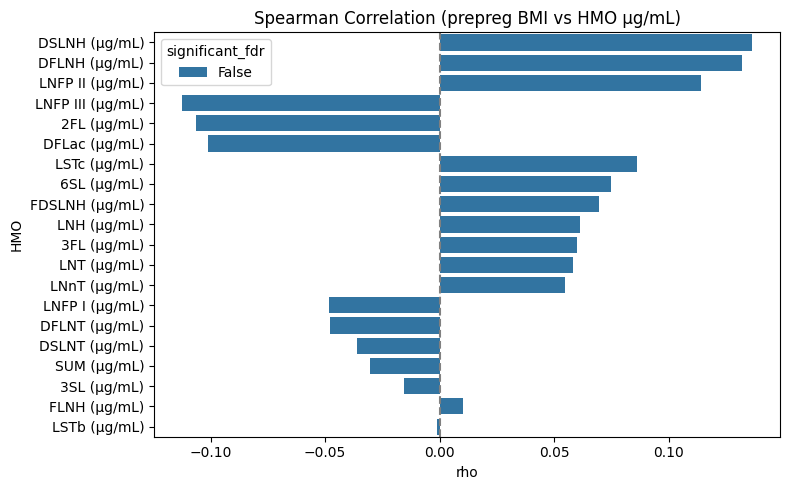

In [ ]:
# Visulization of Spearman correlation

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='rho', y='HMO', hue='significant_fdr', dodge=False)
plt.axvline(0, color='grey', linestyle='--')
plt.title('Spearman Correlation (prepreg BMI vs HMO µg/mL)')
plt.tight_layout()
plt.show()


In [28]:
hmo_cols = [c for c in df.columns if '(µg/mL)' in c]
results = []

for hmo in hmo_cols:
    subset = df[['secretor_status', hmo]].dropna()
    rho, pval = spearmanr(subset['secretor_status'], subset[hmo])
    results.append({'HMO': hmo, 'rho': rho, 'pval': pval})

results_df = pd.DataFrame(results)
results_df['significant'] = results_df['pval'] <= 0.05

# FDR correction
reject, pvals_corrected, _, _ = multipletests(results_df['pval'], method='fdr_bh')

# Add corrected results to your DataFrame
results_df['pval_fdr'] = pvals_corrected
results_df['significant_fdr'] = reject
results_df.sort_values('pval', inplace=True)
results_df

,HMO,rho,pval,significant,pval_fdr,significant_fdr
0,2FL (µg/mL),0.764758,1.469254e-60,True,1.469254e-59,True
2,DFLac (µg/mL),0.764758,1.469254e-60,True,1.469254e-59,True
7,LNFP I (µg/mL),0.760157,1.936685e-59,True,1.291124e-58,True
8,LNFP II (µg/mL),-0.643311,1.726272e-37,True,8.631358e-37,True
17,FDSLNH (µg/mL),-0.639202,6.862001e-37,True,2.744800e-36,True
12,DFLNT (µg/mL),0.629835,1.477160e-35,True,4.923868e-35,True
5,LNT (µg/mL),-0.581683,2.272686e-29,True,6.493389e-29,True
19,SUM (µg/mL),0.577082,7.852496e-29,True,1.963124e-28,True
16,DFLNH (µg/mL),-0.565578,1.601925e-27,True,3.559833e-27,True
1,3FL (µg/mL),-0.507648,1.207488e-21,True,2.414976e-21,True


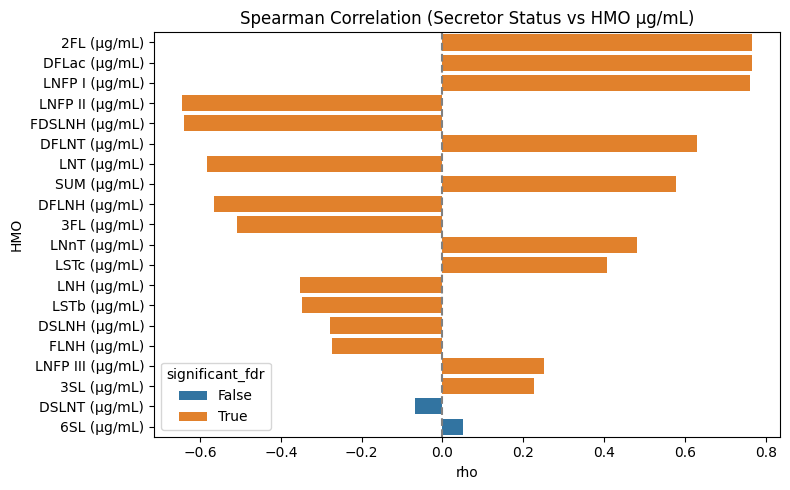

In [30]:
# Visulization of Spearman correlation

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='rho', y='HMO', hue='significant_fdr', dodge=False)
plt.axvline(0, color='grey', linestyle='--')
plt.title('Spearman Correlation (Secretor Status vs HMO µg/mL)')
plt.tight_layout()
plt.show()

In [31]:
hmo_cols = [c for c in df.columns if '(µg/mL)' in c]
results = []

for hmo in hmo_cols:
    subset = df[['PP_day_num', hmo]].dropna()
    rho, pval = spearmanr(subset['PP_day_num'], subset[hmo])
    results.append({'HMO': hmo, 'rho': rho, 'pval': pval})

results_df = pd.DataFrame(results)
results_df['significant'] = results_df['pval'] <= 0.05

# FDR correction
reject, pvals_corrected, _, _ = multipletests(results_df['pval'], method='fdr_bh')

# Add corrected results to your DataFrame
results_df['pval_fdr'] = pvals_corrected
results_df['significant_fdr'] = reject
results_df.sort_values('pval', inplace=True)
results_df

,HMO,rho,pval,significant,pval_fdr,significant_fdr
15,FLNH (µg/mL),0.717538,3.814272e-50,True,7.628544e-49,True
3,3SL (µg/mL),-0.601584,8.440534e-32,True,8.440534e-31,True
5,LNT (µg/mL),0.456219,2.732176e-17,True,1.821451e-16,True
9,LNFP III (µg/mL),-0.415390,2.549784e-14,True,1.274892e-13,True
2,DFLac (µg/mL),-0.400340,2.533984e-13,True,1.013594e-12,True
4,6SL (µg/mL),0.391211,9.652856e-13,True,3.217619e-12,True
10,LSTb (µg/mL),-0.361066,6.018502e-11,True,1.719572e-10,True
16,DFLNH (µg/mL),-0.301485,6.502289e-08,True,1.625572e-07,True
13,LNH (µg/mL),0.290326,2.046022e-07,True,4.546716e-07,True
0,2FL (µg/mL),-0.275419,8.777680e-07,True,1.755536e-06,True


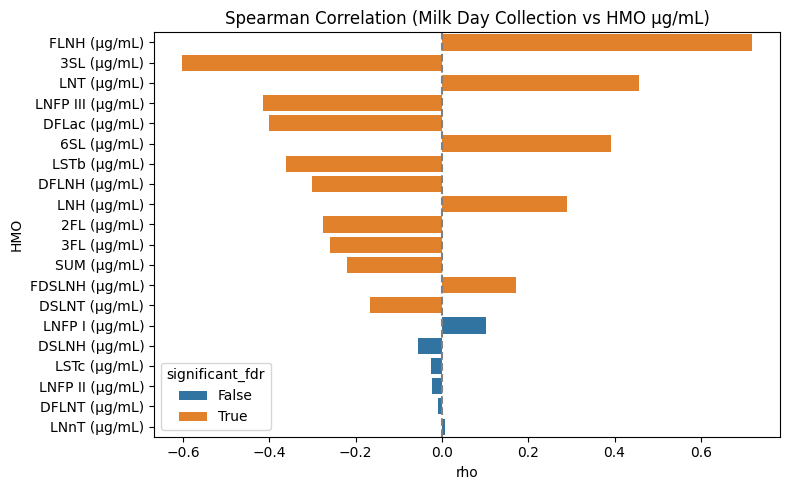

In [32]:
# Visulization of Spearman correlation

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='rho', y='HMO', hue='significant_fdr', dodge=False)
plt.axvline(0, color='grey', linestyle='--')
plt.title('Spearman Correlation (Milk Day Collection vs HMO µg/mL)')
plt.tight_layout()
plt.show()

#### Test the Interaction Between Secretor Status x PP_day_num
- So far correlations collapsed all samples together - ignoring each mom contribues multiple days so transition to an LMM
    - How HMOs change with day
    - Wether that change differs by secretor status

In [ ]:
# make sure types are right
df['PP_day_num'] = pd.to_numeric(df['PP_day_num'], errors='coerce')
df['secretor_status'] = df['secretor_status'].astype('category')

sub = df[['2FL (µg/mL)', 'PP_day_num', 'secretor_status', 'Participant ID']].dropna()

formula = 'Q("2FL (µg/mL)") ~ PP_day_num * C(secretor_status)'    #Q quotes the HMO column
model = smf.mixedlm(formula, data=sub, groups=sub['Participant ID'])
res = model.fit(method='lbfgs')
print(res.summary())


                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         Q("2FL (µg/mL)")
No. Observations:         309             Method:                     REML            
No. Groups:               145             Scale:                      608818.2023     
Min. group size:          1               Log-Likelihood:             -2577.5092      
Max. group size:          5               Converged:                  Yes             
Mean group size:          2.1                                                         
--------------------------------------------------------------------------------------
                                      Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------------------------------
Intercept                              144.876  321.260  0.451 0.652 -484.782  774.533
C(secretor_status)[T.1]               5647.784  374.450 15.083 0.000

- Interpretation:
    - intercept = Represents the predicted 2’FL concentration for the reference group (non-secretors) at postpartum day 0 (the “baseline day”). The value itself doesn’t matter much biologically — the important terms are below. Not sig
    - C(secretor_status)[T.1] = 5647.784, p < 0.001 = At day 0, secretors have ~5648 µg/mL higher 2’FL than non-secretors. This aligns perfectly with biology — 2’FL is a fucosylated HMO produced only in secretors.
    - PP_day_num = 3.206, p = 0.966 (n.s.) - For non-secretors, 2’FL concentration doesn’t change over postpartum days.
    - PP_day_num × secretor_status[T.1] = –517.515, p < 0.001 - The slope of 2’FL concentration over days differs by secretor group. Specifically, 2’FL in secretors decreases by about 517 µg/mL per day relative to non-secretors.

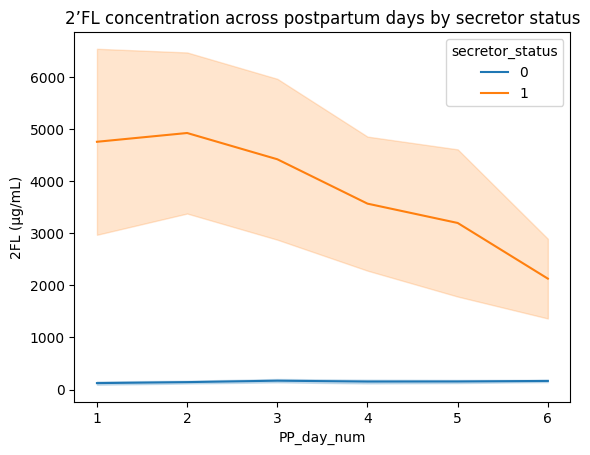

In [36]:
sns.lineplot(
    data=df,
    x='PP_day_num', y='2FL (µg/mL)',
    hue='secretor_status', estimator='mean', errorbar='sd'
)
plt.title('2’FL concentration across postpartum days by secretor status')
plt.show()

In [37]:
hmo_cols = [c for c in df.columns if '(µg/mL)' in c]
rows = []

for hmo in hmo_cols:
    sub = df[[hmo, 'PP_day_num', 'secretor_status', 'Participant ID']].dropna()
    if sub.empty:
        continue

    try:
        formula = f'Q("{hmo}") ~ PP_day_num * C(secretor_status)'
        res = smf.mixedlm(formula, data=sub, groups=sub['Participant ID']).fit(method='lbfgs', reml=True)

        # collect coefficients and p-values for key terms
        terms = res.pvalues.index
        def grab(term):
            match = [t for t in terms if term in t]
            if match:
                return res.params[match[0]], res.pvalues[match[0]]
            else:
                return (float('nan'), float('nan'))

        b_secretor, p_secretor = grab('C(secretor_status)')
        b_day, p_day = grab('PP_day_num')
        b_inter, p_inter = grab('PP_day_num:C(secretor_status)')

        rows.append({
            'HMO': hmo,
            'beta_secretor': b_secretor, 'p_secretor': p_secretor,
            'beta_day': b_day,           'p_day': p_day,
            'beta_interaction': b_inter, 'p_interaction': p_inter
        })
    except Exception as e:
        rows.append({'HMO': hmo, 'error': str(e)})

results = pd.DataFrame(rows)

# ---- FDR correction for each family of tests ----
for col in ['p_secretor', 'p_day', 'p_interaction']:
    mask = results[col].notna()
    reject, qvals, _, _ = multipletests(results.loc[mask, col], method='fdr_bh')
    results.loc[mask, f'q_{col[2:]}'] = qvals
    results.loc[mask, f'sig_{col[2:]}'] = reject

# tidy output
results = results.sort_values('q_interaction')
results.reset_index(drop=True, inplace=True)
results.head(20)


/Users/kspann/.hmo-kernel/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/kspann/.hmo-kernel/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/kspann/.hmo-kernel/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/kspann/.hmo-kernel/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/kspann/.hmo-kernel/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/kspann/.hmo-kernel/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: User

,HMO,beta_secretor,p_secretor,beta_day,p_day,beta_interaction,p_interaction,q_secretor,sig_secretor,q_day,sig_day,q_interaction,sig_interaction
0,DFLac (µg/mL),1578.455202,7.005105e-26,-0.551132,9.869047e-01,-301.291866,2.635768e-14,4.670070e-25,True,9.869047e-01,False,5.271537e-13,True
1,FDSLNH (µg/mL),-57.887819,1.595668e-01,81.006837,1.384285e-20,-65.305508,1.487442e-10,1.679650e-01,False,1.384285e-19,True,1.487442e-09,True
2,2FL (µg/mL),5647.784094,2.098738e-51,3.206368,9.662576e-01,-517.515085,5.821807e-09,4.197476e-50,True,9.869047e-01,False,3.881205e-08,True
3,3SL (µg/mL),299.978633,1.808516e-06,-29.207800,3.618604e-02,-58.347507,4.125227e-04,3.288210e-06,True,9.046510e-02,False,1.528270e-03,True
4,DFLNH (µg/mL),-252.413257,3.404788e-27,-32.845676,3.829105e-12,19.442573,4.584811e-04,3.404788e-26,True,2.552736e-11,True,1.528270e-03,True
5,LSTb (µg/mL),-130.464185,9.867302e-12,-26.311519,1.192460e-10,17.266499,3.085594e-04,2.819229e-11,True,5.962302e-10,True,1.528270e-03,True
6,LNFP I (µg/mL),919.685314,3.096524e-05,5.519851,9.068447e-01,177.164745,1.463358e-03,4.763883e-05,True,9.869047e-01,False,3.658395e-03,True
7,LNFP III (µg/mL),43.763011,2.924843e-06,-2.675317,1.786886e-01,-7.566792,1.297986e-03,4.874738e-06,True,3.248883e-01,False,3.658395e-03,True
8,LNH (µg/mL),-102.525281,9.800722e-08,0.754458,8.537051e-01,14.103006,3.320292e-03,1.960144e-07,True,9.869047e-01,False,5.533820e-03,True
9,DSLNT (µg/mL),-126.524736,7.362755e-04,-28.227463,3.542702e-04,27.674077,2.906541e-03,1.051822e-03,True,1.417081e-03,True,5.533820e-03,True


In [50]:
sig_results = results[
    (results['sig_secretor']) | 
    (results['sig_day']) | 
    (results['sig_interaction'])
]

cols_to_export = [
    'HMO',
    'beta_secretor', 'q_secretor', 'sig_secretor',
    'beta_day', 'q_day', 'sig_day',
    'beta_interaction', 'q_interaction', 'sig_interaction'
]
sig_table = sig_results[cols_to_export]

sig_table.to_excel('significant_HMO_results.xlsx', index=False)



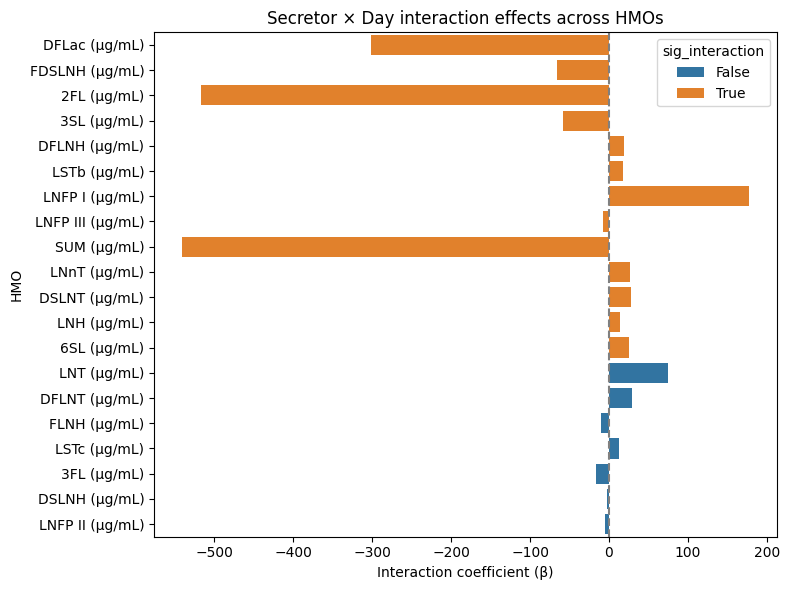

In [39]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=results.sort_values('q_interaction'),
    y='HMO', x='beta_interaction', hue='sig_interaction', dodge=False
)
plt.axvline(0, color='grey', linestyle='--')
plt.title('Secretor × Day interaction effects across HMOs')
plt.xlabel('Interaction coefficient (β)')
plt.tight_layout()
plt.show()


<Axes: xlabel='PP_day_num', ylabel='SUM (µg/mL)'>

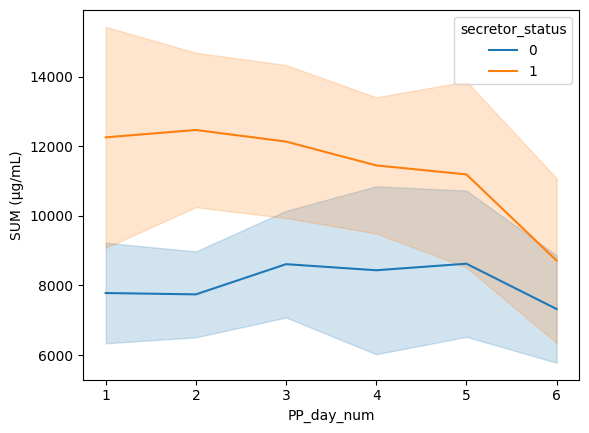

In [42]:
sns.lineplot(
    data=df, x='PP_day_num', y='SUM (µg/mL)',
    hue='secretor_status', estimator='mean', errorbar='sd'
)

<Axes: xlabel='PP_day_num', ylabel='LNFP I (µg/mL)'>

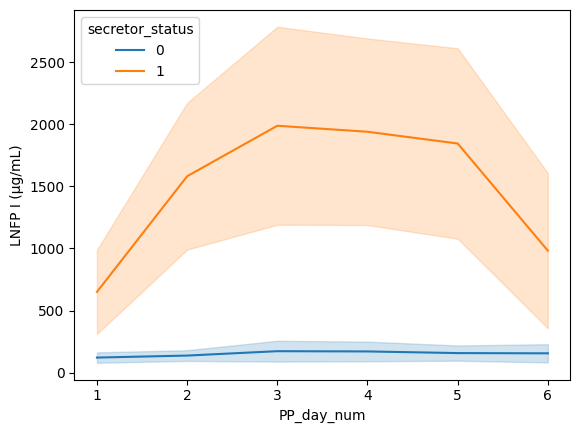

In [43]:
sns.lineplot(
    data=df, x='PP_day_num', y='LNFP I (µg/mL)',
    hue='secretor_status', estimator='mean', errorbar='sd'
)

### How Milk Stage Impacts HMO comp

In [53]:
def classify_milk_stage(day):
    if day <= 4:
        return "Colostrum"
    elif day == 5:
        return "Transitional"
    else:
        return "Mature"

df["MilkStage"] = df["PP_day_num"].apply(classify_milk_stage)


In [ ]:
# does not account for repeated moms
from scipy.stats import kruskal
groups = [group[hmo].dropna() for name, group in df.groupby("MilkStage")]
stat, pval = kruskal(*groups)
print(f"{hmo}: Kruskal–Wallis p = {pval:.4e}")

SUM (µg/mL): Kruskal–Wallis p = 5.6289e-07


In [56]:
formula = f'Q("{hmo}") ~ C(MilkStage) * C(secretor_status)'
model = smf.mixedlm(formula, data=df, groups=df["Participant ID"]).fit()
print(model.summary())


                                  Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               Q("SUM (µg/mL)")
No. Observations:                309                   Method:                           REML            
No. Groups:                      145                   Scale:                            2774459.0607    
Min. group size:                 1                     Log-Likelihood:                   -2755.1673      
Max. group size:                 5                     Converged:                        Yes             
Mean group size:                 2.1                                                                     
---------------------------------------------------------------------------------------------------------
                                                        Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------------------

/var/folders/c8/_21cxjf54_5d0qsx2dqt5qgc0000gp/T/ipykernel_82583/3217648558.py:11: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


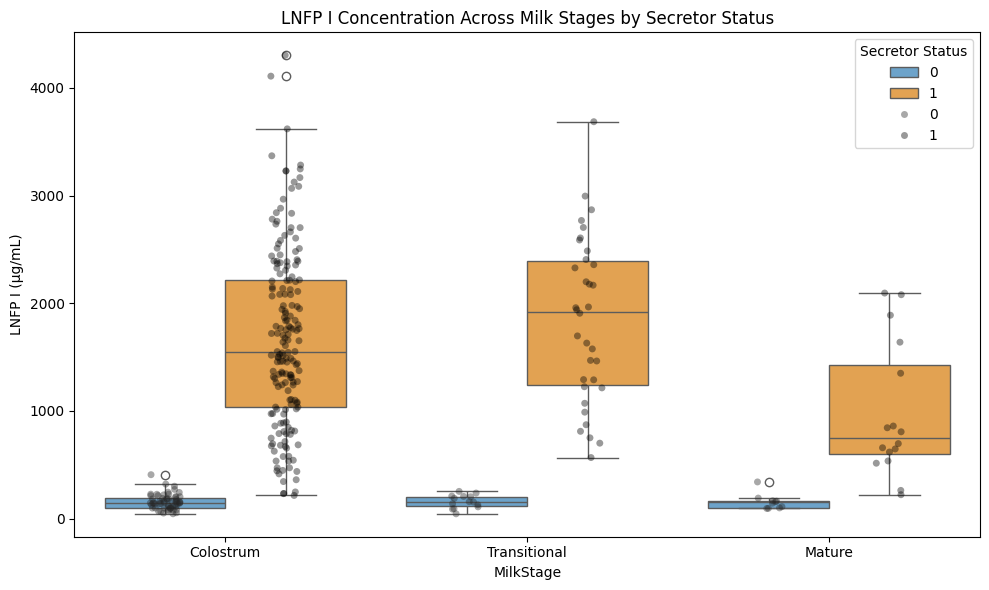

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(
    data=df,
    x="MilkStage", y="LNFP I (µg/mL)",
    hue="secretor_status",
    palette=["#5DA5DA","#FAA43A"]
)
sns.stripplot(
    data=df,
    x="MilkStage", y="LNFP I (µg/mL)",
    hue="secretor_status", dodge=True,
    alpha=0.4, color="black"
)
plt.title("LNFP I Concentration Across Milk Stages by Secretor Status")
plt.legend(title="Secretor Status")
plt.tight_layout()
plt.show()


In [59]:
hmo_pct_cols = [c for c in df.columns if '(%)' in c]

stage_means = (
    df.groupby('MilkStage')[hmo_pct_cols]
      .mean()
      .T
      .sort_values(by='Colostrum', ascending=False)
)
stage_means.head()


MilkStage,Colostrum,Mature,Transitional
SUM (%),100.000000,100.000000,100.000000
2FL (%),36.338784,23.348089,29.281171
LNT (%),10.579331,15.390332,16.482047
LNFP I (%),8.709577,6.325362,10.000367
3FL (%),7.857122,14.715032,5.958069


/var/folders/c8/_21cxjf54_5d0qsx2dqt5qgc0000gp/T/ipykernel_82583/427281817.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('MilkStage')[hmo_pct_cols]


<Figure size 1000x600 with 0 Axes>

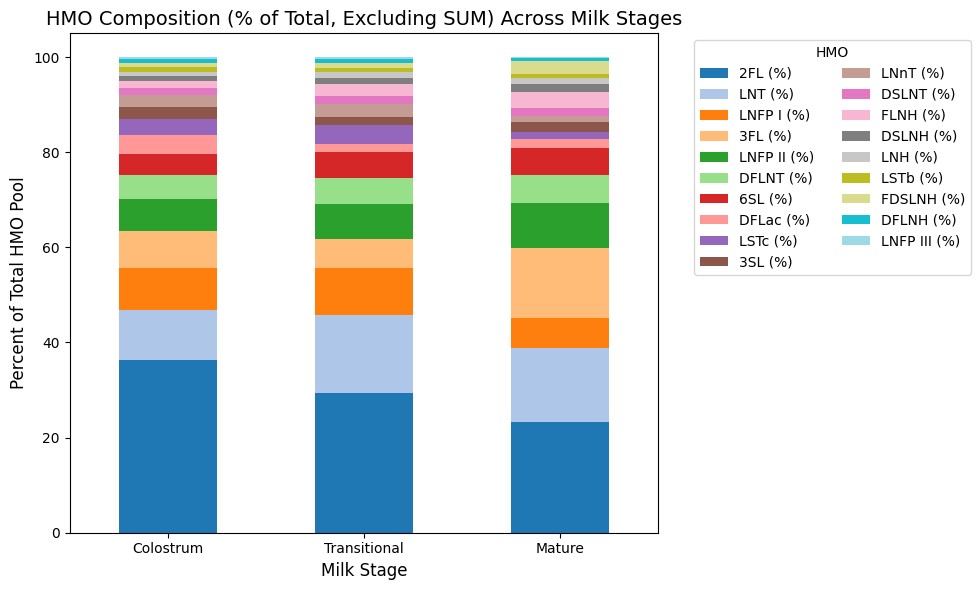

In [68]:
# Explicitly set stage order
df['MilkStage'] = pd.Categorical(
    df['MilkStage'],
    categories=['Colostrum', 'Transitional', 'Mature'],
    ordered=True
)

# Now recompute stage_means
stage_means = (
    df.groupby('MilkStage')[hmo_pct_cols]
      .mean()
      .T
)

# Optional: sort by abundance in colostrum
stage_means = stage_means.sort_values(by='Colostrum', ascending=False)

# Plot again
plt.figure(figsize=(10,6))
stage_means.T.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    colormap='tab20'
)

plt.title("HMO Composition (% of Total, Excluding SUM) Across Milk Stages", fontsize=14)
plt.ylabel("Percent of Total HMO Pool", fontsize=12)
plt.xlabel("Milk Stage", fontsize=12)
plt.xticks(rotation=0)
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    ncol=2,
    title='HMO'
)
plt.tight_layout()
plt.show()


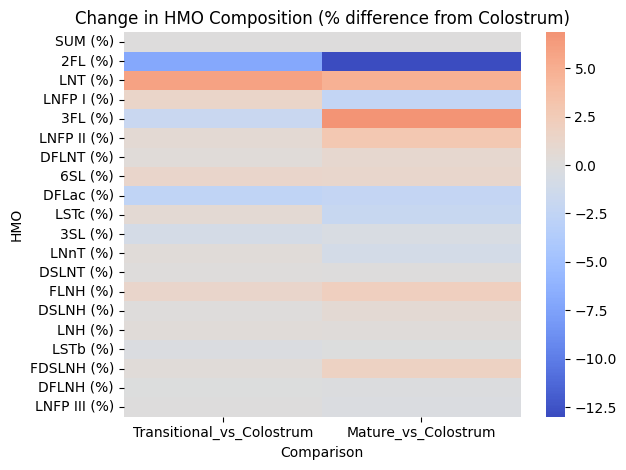

In [69]:
sns.heatmap(fc[['Transitional_vs_Colostrum','Mature_vs_Colostrum']],
            cmap='coolwarm', center=0)
plt.title("Change in HMO Composition (% difference from Colostrum)")
plt.xlabel("Comparison")
plt.ylabel("HMO")
plt.tight_layout()
plt.show()

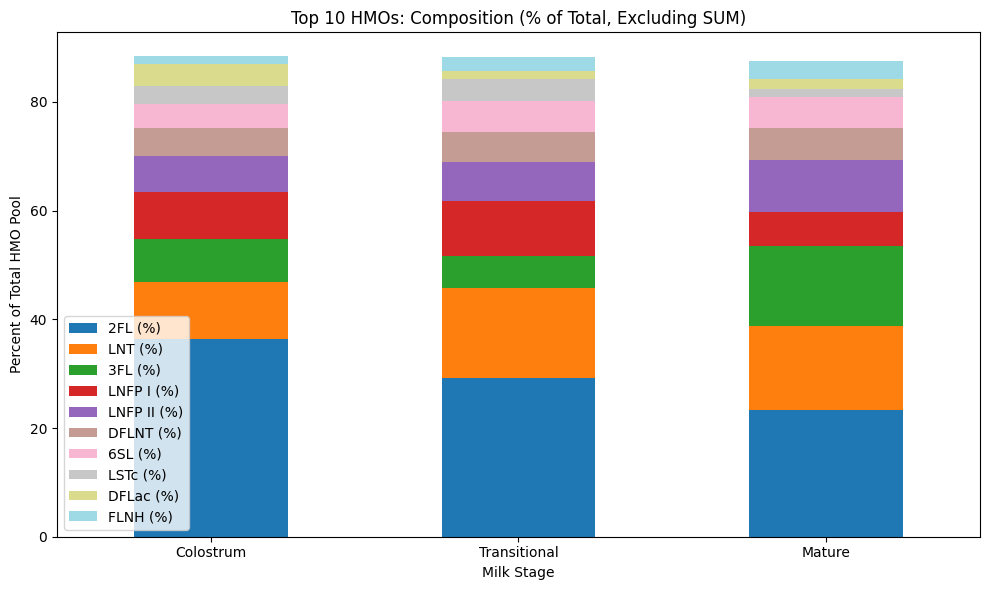

In [70]:
top_hmos = stage_means.mean(axis=1).sort_values(ascending=False).head(10).index
stage_means_top = stage_means.loc[top_hmos]

stage_means_top.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title("Top 10 HMOs: Composition (% of Total, Excluding SUM)")
plt.ylabel("Percent of Total HMO Pool")
plt.xlabel("Milk Stage")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


##### Take into Account Specific Moms

In [ ]:
model = smf.mixedlm(
    'Q("2FL (%)") ~ C(MilkStage, Treatment(reference="Colostrum"))',
    data=df,
    groups=df["Participant ID"],      # random intercept for mom
    re_formula="~C(MilkStage)"        # optional: random slope per stage
)
res = model.fit(method='lbfgs')
print(res.summary())


                                  Mixed Linear Model Regression Results
Model:                            MixedLM                 Dependent Variable:                 Q("2FL (%)")
No. Observations:                 309                     Method:                             REML        
No. Groups:                       145                     Scale:                              22.4244     
Min. group size:                  1                       Log-Likelihood:                     -1171.2188  
Max. group size:                  5                       Converged:                          Yes         
Mean group size:                  2.1                                                                     
----------------------------------------------------------------------------------------------------------
                                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------

/Users/kspann/.hmo-kernel/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


/var/folders/c8/_21cxjf54_5d0qsx2dqt5qgc0000gp/T/ipykernel_82583/2080531390.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(


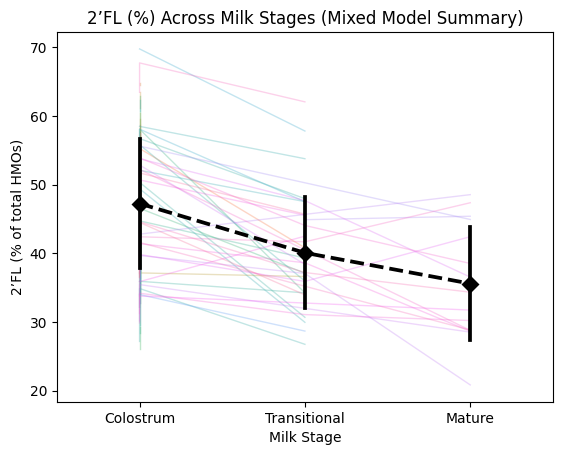

In [ ]:
sec = df[df['secretor_status'] == 1].copy()

sns.lineplot(
    data=sec,
    x='MilkStage', y='2FL (%)',
    hue='Participant ID',
    estimator=None, alpha=0.3, linewidth=1
)
sns.pointplot(
    data=sec,
    x='MilkStage', y='2FL (%)',
    color='black', ci='sd', markers='D', linestyles='--'
)
plt.title("Secretor 2’FL (%) Across Milk Stages (Mixed Model Summary)")
plt.ylabel("2’FL (% of total HMOs)")
plt.xlabel("Milk Stage")
plt.legend([],[], frameon=False)   #remove list of IDs on the graph
plt.show()



## Multivariable Linear Models
- Focus on a few key outcomes with predictors

## Linear Mixed Models
- For repeated measures, implement mixed models with participant as a random effect
- And use multiple testing correction (FDR/q-values) for the exploratory correlation phase.

In [ ]:
mixedlm('`2FL (µg/mL)` ~ PP_day_num + DeliveryMethod + secretor_status',
        groups='Participant ID', data=df).fit()
